In [1]:
import torch
from transformers import BertTokenizer, BertModel
import csv
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import numpy as np
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Function to read CSV file and extract columns
def read_csv(file_path):
    columns = {}
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for column in reader.fieldnames:
            columns[column] = []
        for row in reader:
            for column in reader.fieldnames:
                columns[column].append(row[column])
    return columns

def split_response(input):
    input = "\\n\\n1)" + input[34:-57]

    result = re.split(r'\\n\\n\d\)', input)
    for i in range(len(result)):
        result[i] = re.split(r'(\\n\d\.\d\d?|\\n\d\.\d)', result[i])

    for i in range(len(result)):
        indicesToRemove = []
        for j in range(len(result[i])):
            if len(result[i][j]) < 8:
                indicesToRemove.append(j)
        indicesToRemove.reverse()
        for j in indicesToRemove:
            result[i].remove(result[i][j])
    return result[1:]



c:\Users\laela\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpt_separate = read_csv("C:/Users/laela/Downloads/Separate_Pairs_FINAL_Result_wGPT.csv")["GPT"]
cagpt_separate = read_csv("C:/Users/laela/Downloads/Separate_Pairs_FINAL_Result_wGPT.csv")["CAGPT"]
gpt_mixed = read_csv("C:/Users/laela/Downloads/Mixed_Pairs_FINAL_Result_wGPT.csv")["GPT"]
cagpt_mixed= read_csv("C:/Users/laela/Downloads/Mixed_Pairs_FINAL_Result_wGPT.csv")["CAGPT"]

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

gpt = gpt_separate + gpt_mixed
cagpt = cagpt_separate + cagpt_mixed

# Define function to obtain BERT embeddings
def get_bert_embeddings(tokenized_input):
    with torch.no_grad():
        outputs = model(**tokenized_input)
        # Consider the output of the [CLS] token as the embedding for the entire sequence
        embeddings = outputs.last_hidden_state[:, 0, :]
    return embeddings.numpy()

# Initialize lists to store BERT embeddings
gpt_embeddings = []
cagpt_embeddings = []

for i in range(len(gpt)):
    gpt[i] = split_response(gpt[i])

for i in range(len(cagpt)):
    cagpt[i] = split_response(cagpt[i])

for i in range(len(gpt)):
    if len(gpt[i]) != 5:
        gpt.remove(gpt[i])
        i = i-1
    if i+1 == len(gpt):
        break

for i in range(len(cagpt)):
    if len(cagpt[i]) != 5:
        cagpt.remove(cagpt[i])
        i = i-1
    if i+1 == len(cagpt):
        break

# Process tokenized inputs and obtain BERT embeddings for 'gpt'
for i in tqdm(range(len(gpt))):
    for question in gpt[i]:
        for subquestion in question:
            tokenized_inputs = [tokenizer.encode_plus(subquestion, add_special_tokens=True, truncation=True, max_length=256, return_tensors='pt', padding=True) ]
            embeddings = [get_bert_embeddings(tokenized_input) for tokenized_input in tokenized_inputs]
            gpt_embeddings.append(embeddings)

# Process tokenized inputs and obtain BERT embeddings for 'cagpt'
for i in tqdm(range(len(cagpt))):
    for question in cagpt[i]:
        for subquestion in question:
            tokenized_inputs = [tokenizer.encode_plus(subquestion, add_special_tokens=True, truncation=True, max_length=256, return_tensors='pt', padding=True)]
            embeddings = [get_bert_embeddings(tokenized_input) for tokenized_input in tokenized_inputs]
            cagpt_embeddings.append(embeddings)

100%|██████████| 376/376 [05:10<00:00,  1.21it/s]


In [3]:
import pickle

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('C:/Users/laela/Downloads/gpt_embeddings.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(gpt_embeddings, f)

with open('C:/Users/laela/Downloads/cagpt_embeddings.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump(cagpt_embeddings, f)


In [4]:
trimmed_gpt_embeddings = []
trimmed_cagpt_embeddings = []
chosen_word = 201
for i in range(len(gpt_embeddings)):
    trimmed_gpt_embeddings.append(gpt_embeddings[i][0][0])
for i in range(len(cagpt_embeddings)):
    trimmed_cagpt_embeddings.append(cagpt_embeddings[i][0][0])
trimmed_combined_embeddings = np.array(trimmed_gpt_embeddings + trimmed_cagpt_embeddings)

In [5]:
#KMeans model
class KMeans:
    def __init__(self, max_iters=300):
        self.n_clusters = None
        self.max_iters = max_iters

    def compute_inertia(self, X):
        inertia = 0
        for point in X:
            similarities = [np.dot(point, centroid) / (np.linalg.norm(point) * np.linalg.norm(centroid)) for centroid in self.centroids]
            closest_cluster_idx = np.argmax(similarities)
            inertia += np.linalg.norm(point - self.centroids[closest_cluster_idx])**2
        return inertia

    def fit(self, X, n_clusters=None):
        if n_clusters is not None:
            self.n_clusters = n_clusters
        self.centroids = X[np.random.choice(range(len(X)), self.n_clusters, replace=False)]
        
        for _ in range(self.max_iters):
            # Assigns each data point to the nearest centroid
            clusters = [[] for _ in range(self.n_clusters)]
            for point in X:
                similarities = [np.dot(point, centroid) / (np.linalg.norm(point) * np.linalg.norm(centroid)) for centroid in self.centroids]
                closest_cluster_idx = np.argmax(similarities)
                clusters[closest_cluster_idx].append(point)
            
            # Updates centroids based on the mean of the points assigned to each cluster
            new_centroids = []
            for cluster in clusters:
                if cluster:
                    new_centroids.append(np.mean(cluster, axis=0))
                else:
                    # Doesn't change empty centroids
                    new_centroids.append(self.centroids[len(new_centroids)])
                    
            # Checks for convergence
            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

    def predict(self, X):
        predictions = []
        for point in X:
            similarities = [np.dot(point, centroid) / (np.linalg.norm(point) * np.linalg.norm(centroid)) for centroid in self.centroids]
            closest_cluster_idx = np.argmax(similarities)
            predictions.append(closest_cluster_idx)
        return np.array(predictions)

In [7]:
trimmed_combined_embeddings = np.array(trimmed_gpt_embeddings + trimmed_cagpt_embeddings)
k_value = 200

print("Using k =", k_value)
kmeans = KMeans()
        
# Initializes and fits the KMeans model
kmeans.fit(trimmed_combined_embeddings, n_clusters=k_value)
final_centroids = np.array(kmeans.centroids)

# Gets cluster assignments for the data points
final_predictions=kmeans.predict(trimmed_combined_embeddings)
print("Silhouette score for k =", k_value,":", silhouette_score(trimmed_combined_embeddings, final_predictions))

print(len(trimmed_combined_embeddings))

    

Using k = 200
Silhouette score for k = 200 : 0.09741827
19767


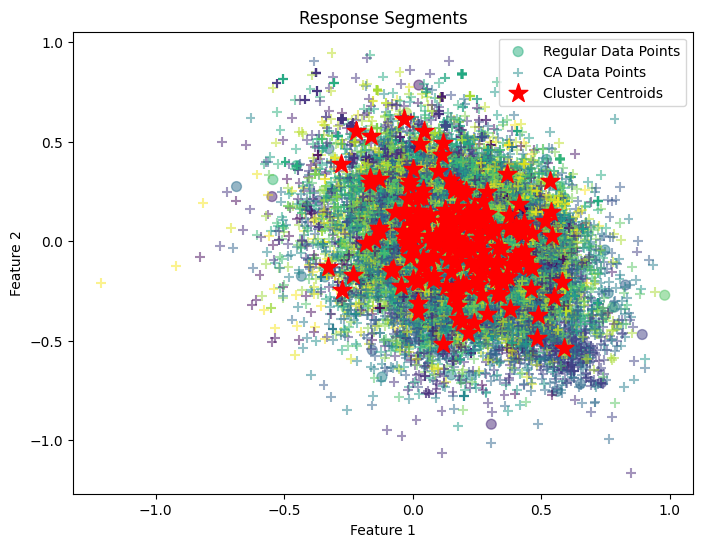

In [8]:
# Visualize the clusters
feature_1 = 98
feature_2 = 73


class_labels = [0] * 377 + [1] * 377
plt.figure(figsize=(8, 6))
plt.scatter(trimmed_combined_embeddings[:377, feature_1], trimmed_combined_embeddings[:377, feature_2], c=final_predictions[:377], s=50, cmap='viridis', alpha=0.5, label='Regular Data Points')
plt.scatter(trimmed_combined_embeddings[377:, feature_1], trimmed_combined_embeddings[377:, feature_2], c=final_predictions[377:], s=50, cmap='viridis', alpha=0.5, label='CA Data Points', marker="+")
plt.scatter(final_centroids[:,feature_1], final_centroids[:,feature_2], c='red', s=200, marker='*', label='Cluster Centroids')
plt.title('Response Segments')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

In [15]:
gpt_count_per_cluster = {}
cagpt_count_per_cluster = {}
for i in range(200):
    gpt_count_per_cluster[i] = 0
    cagpt_count_per_cluster[i] = 0
for i in range(9192):
    gpt_count_per_cluster[final_predictions[i]] += 1
for i in range(10575):
    cagpt_count_per_cluster[final_predictions[i]] += 1

print(gpt_count_per_cluster)
print(cagpt_count_per_cluster)

for i in range(200):
    if gpt_count_per_cluster[i]:
        print(str(i+1), str(cagpt_count_per_cluster[i]/gpt_count_per_cluster[i]))
    else:
        print(str(i+1), "undefined")


{0: 28, 1: 7, 2: 15, 3: 22, 4: 27, 5: 11, 6: 40, 7: 75, 8: 69, 9: 28, 10: 11, 11: 159, 12: 16, 13: 28, 14: 4, 15: 8, 16: 45, 17: 33, 18: 5, 19: 14, 20: 56, 21: 3, 22: 50, 23: 79, 24: 10, 25: 62, 26: 53, 27: 2, 28: 3, 29: 91, 30: 39, 31: 38, 32: 55, 33: 63, 34: 54, 35: 15, 36: 64, 37: 3, 38: 27, 39: 213, 40: 2, 41: 80, 42: 31, 43: 9, 44: 7, 45: 17, 46: 57, 47: 7, 48: 18, 49: 8, 50: 5, 51: 22, 52: 7, 53: 1, 54: 36, 55: 37, 56: 101, 57: 6, 58: 54, 59: 82, 60: 24, 61: 61, 62: 108, 63: 20, 64: 89, 65: 110, 66: 62, 67: 9, 68: 23, 69: 134, 70: 54, 71: 9, 72: 24, 73: 32, 74: 13, 75: 18, 76: 48, 77: 75, 78: 20, 79: 105, 80: 76, 81: 101, 82: 7, 83: 3, 84: 79, 85: 71, 86: 74, 87: 6, 88: 53, 89: 73, 90: 35, 91: 29, 92: 16, 93: 78, 94: 20, 95: 18, 96: 77, 97: 0, 98: 10, 99: 8, 100: 81, 101: 2, 102: 12, 103: 24, 104: 72, 105: 36, 106: 73, 107: 4, 108: 50, 109: 6, 110: 40, 111: 79, 112: 44, 113: 109, 114: 18, 115: 16, 116: 50, 117: 3, 118: 71, 119: 15, 120: 29, 121: 38, 122: 7, 123: 26, 124: 153, 125

In [16]:
gpt_one_dimension = []
cagpt_one_dimension = []
for i in tqdm(range(len(gpt))):
    for question in gpt[i]:
        for subquestion in question:
            gpt_one_dimension.append(subquestion)
for i in tqdm(range(len(cagpt))):
    for question in cagpt[i]:
        for subquestion in question:
            cagpt_one_dimension.append(subquestion)

100%|██████████| 376/376 [00:00<00:00, 377016.09it/s]


In [29]:
subquestion_text_per_cluster = [[] for _ in range(200)]
for i in range(9192):
    subquestion_text_per_cluster[final_predictions[i]].append("GPT: " + gpt_one_dimension[i])
for i in range(10575):
    subquestion_text_per_cluster[final_predictions[i + 9192]].append("CAGPT: " + cagpt_one_dimension[i])


# Define the filename
filename = "C:/Users/laela/Downloads/subquestion_text_per_cluster.txt"

# Open the file in write mode
with open(filename, "w") as file:
    # Iterate over each cluster
    for cluster_index, cluster_contents in enumerate(subquestion_text_per_cluster):
        # Write the cluster index to the file
        file.write(f"Cluster {cluster_index}:\n")
        
        # Iterate over each item in the cluster
        for item in cluster_contents:
            # Write the item to the file
            try:
                file.write(item + "\n")
            except UnicodeEncodeError as e:
                print(f"UnicodeEncodeError occurred: {e}")
            
        # Write a separator between clusters
        file.write("\n")

UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 122: character maps to <undefined>
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 71: character maps to <undefined>
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 81: character maps to <undefined>
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 88: character maps to <undefined>
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 75: character maps to <undefined>
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 82: character maps to <undefined>
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 70: character maps to <undefined>
UnicodeEncodeError occurred: 'charmap' codec can't encode character '\x9d' in position 138: character maps to <undefined>
UnicodeEncodeError occurred: '